In [142]:
import numpy as np
from tqdm import tqdm, trange
from scipy.sparse import coo_matrix, hstack,vstack
from scipy.interpolate import griddata

from scipy.optimize import fsolve
from scipy import integrate
import sympy as sp

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import deepxde as dde
import time
from timeit import default_timer
import os

In [143]:
a = 1
X = 1
dx = 1 / 20
nx = int(round(X/dx))+1
spatial = np.linspace(0, X, nx, dtype=np.float32)
N1 = len(spatial)
N = N1 - 1                    
# Parameters of NN
epochs =250
ntrain = 900
ntest = 100

gammaS = 0.5
learning_rate = 0.00001
step_size= 30
modes=12
width=32
batch_size = 40


[eta1_m, zeta1_m]= np.meshgrid(spatial,spatial)

In [144]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}
plt.rcParams.update(tex_fonts)

def solveBetaFunction(x, gamma, amp, callback1, callback2):
    beta = np.zeros(len(x))
    for idx, val in enumerate(x):
        beta[idx] = amp*callback1(gamma*callback2(val))
    return beta

def tauFunc(val, gamma, amp):
    #return gamma * np.cos( gamma * np.arccos(val)) 
    return (gamma * amp) * np.exp(-gamma * val)



def gFunc(x, gamma, amp):
    return x - tauFunc(x, gamma, amp)

# 定义反函数
def inverse_function(y, gamma, amp):
    result = fsolve(lambda x: gFunc(x, gamma, amp) - y, np.zeros(len(y)))#第二个参数表示预测的起始值
    return result

def numerical_derivative(f, x, gamma, amp):
    h = 1e-5
    df = (f(x + h, gamma, amp) - f(x - h, gamma, amp)) / (2 * h)
    return df
    
def cFunc(x):
    return 20 - 20 * x


def add_gaussian_noise(x, std_ratio):
    np.random.seed(3)
    x = np.array(x)
    std = std_ratio
    noise = np.random.normal(0, std, size=x.shape)
    return noise

def generateNoise(ampList, cof):
    np.random.seed(0)
    ampArray = np.array(ampList)
    mean = 0  
    variances = np.abs(cof * ampArray )
    gaussian_noises = []
    
    for i in range(len(ampArray)):
        std_dev = variances[i]  
        noise = np.random.normal(mean, std_dev)
        max_noise = variances[i]
        noise = np.clip(noise, -max_noise, max_noise)
        gaussian_noises.append(noise)
    gaussian_noises_array = np.array(gaussian_noises)
    
    return gaussian_noises_array

def fFunc(x, y):
    return 5 * np.cos(2 * np.pi * x) + 5 * np.sin(2 * np.pi * y) 

def buildF(x):
    s_cood, q_cood = np.meshgrid(x, x, indexing="ij")
    return fFunc(s_cood, q_cood)

def get_cof_equ_K_19(i, N1, f1_m, hx, a):
    num = N1 - i - 2
    coff = f1_m[i, i+1:N1-1].T
    cofi1 = coo_matrix((2 * np.ones(num), (range(num), range(num))), shape = (num, num)).tocsr()
    cofi1 = cofi1 + coo_matrix((-1 * np.ones((num - 1)), (range(num - 1),range(1, num))),shape = (num, num)).tocsr()
    cofi3_1 = np.tril(np.ones((num, num))) - np.diag(1 / 2 * np.ones(num))
    cofi3_1 = hx * cofi3_1
    cofi3_2 = np.zeros((num,num))
    for k in range(num):
        cofi3_2[k, 0:k] = f1_m[i + 1: i + k + 1, i + k + 1].T
    cofi3 = -hx / (a) * cofi3_1 * cofi3_2
    cofi = cofi1 + coo_matrix(cofi3).tocsr() 
    return cofi, coff

def KernelCalc2(a , hx, f1_m): 
    fii = np.diag(f1_m)

    cofmed = np.zeros((N1, N1))
    cofmed[:, -1] = 1/ 2 * np.ones((1, N1))
    cof_int_zeta_1 = hx * (np.triu(np.ones((N1, N1))) - cofmed - np.diag(1 / 2 * np.ones(N1)))
    K_ii = -1 / a * np.dot(cof_int_zeta_1, fii)
    K = np.diag(K_ii)

    for i in range(N1 - 3, -1, -1 ):
        [cofi, coff] = get_cof_equ_K_19(i,N1,f1_m,hx,a)
        Kibud = K[i, i] * hx * hx / (2 * a) - hx / a
        Ki = np.linalg.solve(cofi.toarray(), K[i+1,i+1:N1-1].T) + np.linalg.solve(cofi.toarray(), np.dot(Kibud, coff))
        K[i, i+1:N1-1]=Ki.T  
    Kbud = K[0, :]
    return K, Kbud 

def iteration_k(iterationNum, gBar, gamma, amp):
    s, q = np.meshgrid(spatial, spatial, indexing="ij")
    k_0 = np.zeros((N1, N1))

    for i in range(N1):
        for j in range(i, N1):


            ff = lambda theta: 5 * np.cos(2 * np.pi * (theta + s[i, j] - q[i, j])) + 5 * np.sin(2 * np.pi * theta) 
            if s[i, j] - q[i, j] + 1 < gBar:
                g_inverse_s_q_1 = inverse_function([s[i, j] - q[i, j] + 1], gamma, amp)
                g_diff_at_g_inverse_s_q_1 = numerical_derivative(gFunc, g_inverse_s_q_1, gamma, amp)
                k_0[i, j]= -1 * integrate.quad(ff, q[i, j], 1)[0] - cFunc(g_inverse_s_q_1) / g_diff_at_g_inverse_s_q_1
            else:
                k_0[i, j]= -1 * integrate.quad(ff, q[i, j], 1)[0]

    simpsonIntCoe = np.ones((N1, N1))
    simpsonIntCoe[0, :] = 0.5
    simpsonIntCoe[-1, :] = 0.5
    simpsonIntCoe[:, 0] = 0.5
    simpsonIntCoe[:, -1] = 0.5
    
    kSum = k_0
    K_iteration = k_0
    for _ in range(iterationNum):
        K_iteration_temp = np.zeros((N1, N1))
        for ii in range(N1):#s
            for jj in range(ii, N1):#q
                mSequence = np.linspace(0, 1 - q[ii, jj], N1)
                dm = abs(mSequence[2] - mSequence[1])
                rSequence = np.linspace(s[ii, jj], q[ii, jj], N1)
                dr = abs(rSequence[2]-rSequence[1])
                
                mMatrix, rMatrix = np.meshgrid(mSequence, rSequence, indexing="ij")
                f_obj = fFunc(mMatrix + rMatrix, mMatrix + q[ii, jj]) 
                
                x_qCoodinate = np.hstack((s.flatten()[:,None], q.flatten()[:,None]))#为插值提供基准坐标
                k_obj = griddata(x_qCoodinate, K_iteration.ravel(), (mMatrix + s[ii, jj], mMatrix + rMatrix), method="linear", fill_value = 0)
                
                if s[ii, jj] -q[ii, jj] + 1 < gBar:
                    g_inverse_s_q_1 = inverse_function([s[ii, jj] - q[ii, jj] + 1],gamma, amp)
                    rrSequence = np.linspace(g_inverse_s_q_1, 1, N1)
                    drr = abs(rrSequence[2] - rrSequence[1])
                    k2_obj = griddata(x_qCoodinate, K_iteration.ravel(), (tauFunc(gamma, amp, rrSequence) + s[ii, jj] - q[ii, jj] + 1, rrSequence), method="linear", fill_value = 0)
                    K_iteration_temp[ii, jj] = np.sum(dm * dr * f_obj * k_obj * simpsonIntCoe) + np.trapz( k2_obj.squeeze() * cFunc(rrSequence).squeeze(), dx = drr)
                else:
                    K_iteration_temp[ii, jj] = np.sum(dm * dr * f_obj * k_obj * simpsonIntCoe)


        K_iteration = K_iteration_temp      
        kSum =  kSum + K_iteration_temp
    return kSum, kSum[0, :]


def get_cof_1(ht,hx,N,a,f_m1,c,tau):
    N1=N+1
    cof_int_zeta_1_Nplus1 = get_cof_int_zeta_1(N1,hx)
    cof_int_zeta_1 = cof_int_zeta_1_Nplus1 
    cof_int_zeta_1[0, :] = 0
    C1 = a * ht / hx
    Nsquare = (N1) * N
    At1 = coo_matrix(((1-C1) * np.ones(N), (range(1, N1), range(1, N1))),shape = (N1, N1)).tocsr()
    At1 = At1 + coo_matrix((C1 * np.ones(N), (range(1, N1), range(N1-1))),shape = (N1, N1)).tocsr()
    At1 = At1 + ht * coo_matrix(cof_int_zeta_1 * f_m1).tocsr()

    At2 = coo_matrix((N1,Nsquare)).tocsr()
    At2 = At2 + coo_matrix((c[1 : N+1] * ht, (range(1, N1), range(N, N * (N + 1), N))), shape = (N1, Nsquare)).tocsr()
    tauuu = (np.array(tau) * np.ones((N,N+1))).reshape((-1, 1), order = "f")

    ee = ht / (hx * tauuu)
    diag_vale_c = (1 - ee).squeeze()
    diag_vale_l = ee.squeeze()
    diag_vale_l[N - 1 : Nsquare : N] = 0
    diag_vale_l = np.delete(diag_vale_l, -1)

    At4 = coo_matrix((diag_vale_c, (range(Nsquare), range(Nsquare))), shape = (Nsquare,Nsquare)).tocsr()
    At4 = At4 + coo_matrix((diag_vale_l, (range(Nsquare - 1), range(1, Nsquare))),shape = (Nsquare, Nsquare)).tocsr()

    eee = ee[0 : Nsquare : N].squeeze()

    At3 = coo_matrix((eee, (range(N - 1, Nsquare, N), N1 * [N])), shape = (Nsquare, N1)).tocsr()
    Aa1 = vstack((At1, At3))
    Aa2 = vstack((At2, At4))

    return hstack((Aa1, Aa2))


def coefficient_matrix(length):
    obj_matrix = np.triu(np.ones((length, length))) - np.diag(0.5 * np.ones(length))
    obj_matrix[0, :] = 1 / 2
    obj_matrix[:, -1] = 1 / 2
    return obj_matrix * dx * dx


def solve_contrl_U(uu, K,  Kbud, xu, gamma, amp, g_inverse_0):
    x_star = np.hstack((zeta1_m.flatten()[:,None], eta1_m.flatten()[:,None]))
    contrl1 = np.trapz(Kbud * xu, dx = dx)
    sequence2 = np.linspace(0, g_inverse_0, N1)#0\rightarrow g^{-1}(0)
    dx2 = abs(sequence2[1]-sequence2[2])
    u2_temp_y = sequence2 / (tauFunc(sequence2, gamma, amp))
    u2_x, u2_y = np.meshgrid(sequence2, u2_temp_y, indexing="ij")
    u2 = np.diag(griddata(x_star, uu.ravel(), (u2_x, u2_y), method="cubic", fill_value = 0))
    contrl2 = np.trapz(cFunc(sequence2) * u2 , dx = dx2)
    
    
    #control3
    sequence3 = np.linspace(g_inverse_0, 1, N1)#g^{-1}(0)\rightarrow 1
    dx3 = sequence3[1] - sequence3[0]
    coe3 = np.tril(np.ones((N1, N1))) - np.diag(0.5 * np.ones(N1)) 
    coe3[0, :] = 0.5
    coe3[:, -1] = 0.5
    coem3 = coe3 * dx3 * dx3
    
    u3_x, u3_y_0 = np.meshgrid(sequence3, sequence3, indexing="ij") 
    u3_y = u3_x / tauFunc(u3_x, gamma, amp)#\frac{p}{\tau (q)}
    #对u,k插值
    u3 = griddata(x_star, uu.ravel(), (u3_x, u3_y), method="cubic", fill_value = 0)  
    K_control3 = griddata(x_star, K.ravel(), (u3_x, u3_y_0), method="cubic", fill_value = 0)
    c_m3 = np.tile(cFunc(sequence3), (N1, 1))
    contrl3 = np.sum(c_m3 * K_control3 * u3 * coem3)

    #control4
    sequence4 = sequence2
    dx4 = dx2
    coe4 = np.tril(np.ones((N1, N1))) - np.diag(0.5 * np.ones(N1)) 
    coe4[0, :] = 0.5
    coe4[:, -1] = 0.5
    coem4 = coe4 * dx4 * dx4
    
    u4_x, u4_y_0 = np.meshgrid(sequence4, sequence4, indexing="ij") 
    u4_y = u4_x / tauFunc(u4_x, gamma, amp)#\frac{p}{\tau (q)}
    #对u,k插值
    u4 = griddata(x_star, uu.ravel(), (u4_x, u4_y), method="cubic", fill_value = 0)  
    K_control4 = griddata(x_star, K.ravel(), (u4_x, u4_y_0), method="cubic", fill_value = 0)
    c_m4 = np.tile(cFunc(sequence4), (N1, 1))
    contrl4 = np.sum(c_m4 * K_control4 * u4 * coem4)

    U = contrl1 - contrl2 + contrl3 + contrl4
    return U

def solve_contrl_U2(uu, tau, Kbud, xu, coe_m):#大时滞的控制器函数
    u1_temp_y = spatial / (a * tau)
    u1_x, u1_y = np.meshgrid(spatial, u1_temp_y)

    u2_temp_y = spatial / (a * tau)
    u2_x, u2_y = np.meshgrid(spatial, u2_temp_y)
    
    x_star = np.hstack((zeta1_m.flatten()[:,None], eta1_m.flatten()[:,None]))

    #插值求解
    u1 = np.diag(griddata(x_star, uu.ravel(), (u1_x, u1_y), method="cubic", fill_value = 0))
    u2 = griddata(x_star, uu.ravel(), (u2_x, u2_y), method="cubic", fill_value = 0)  

    contrl1 = np.trapz( Kbud * xu, dx = dx)
    contrl2 = np.trapz(cFunc(spatial) * u1 / a, dx = dx)
    #处理c
    c_m = np.tile(cFunc(spatial), (nx, 1))
    contrl3 = np.sum(c_m * K * u2 * coe_m)
    U = contrl1 - contrl2 + contrl3
    return U




def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def get_cof_int_zeta_1(N,hx):
    cofmed = np.zeros((N,N))
    cofmed[:, N - 1] = 1 / 2 * np.ones((1,N))
    cof_int_zeta_1 = hx * (np.triu(np.ones((N,N))) - cofmed - np.diag(1 / 2 * np.ones(N)))
    return cof_int_zeta_1


def coefficient_matrix(length):
    obj_matrix = np.triu(np.ones((length, length))) - np.diag(0.5 * np.ones(length))
    obj_matrix[0, :] = 1 / 2
    obj_matrix[:, -1] = 1 / 2
    return obj_matrix * dx * dx



In [145]:
f1_m = buildF(spatial)
fii = np.diag(f1_m)

reTrain = False

In [146]:
if reTrain == True:
    sub_xy =  1
    inpArr1 = np.loadtxt("../dataset/input95.dat", dtype=np.float32)
    outArr1 = np.loadtxt("../dataset/U95.dat", dtype=np.float32)

    inpArr2 = np.loadtxt("../dataset/input1025.dat", dtype=np.float32)
    outArr2 = np.loadtxt("../dataset/output1025.dat", dtype=np.float32)

    xxx = np.vstack((inpArr1, inpArr2))
    yyy = np.hstack((outArr1, outArr2))


    x_train, x_test, y_train, y_test = train_test_split(xxx[::sub_xy, :], yyy[::sub_xy], test_size=0.1, random_state=1)
    x_train = torch.from_numpy(x_train).cuda()
    y_train = torch.from_numpy(y_train).cuda()
    x_test = torch.from_numpy(x_test).cuda()
    y_test = torch.from_numpy(y_test).cuda()

    trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
    testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))


In [147]:
################二维网格###############
grids = []
grids.append(np.linspace(0, 1, nx, dtype=np.float32))
grids.append(spatial * spatial)
grid2 = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T  # *表示，接受任意多个参数并将其放在一个元组中
grid2 = torch.from_numpy(grid2).cuda()
class BranchNet(nn.Module):
    def __init__(self, shape):#shape = nx
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(3, 64, 5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(64,128, 5, stride=2)
        self.fc1 = torch.nn.Linear(1152, 256)

        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 3, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        return x
    
class DeepONetModified(nn.Module):
    def __init__(self, m2, branch_2dim, dim_x, projection):
        super(DeepONetModified, self).__init__()
        self.net1 = dde.nn.DeepONetCartesianProd([m2, branch_2dim], [dim_x, 64 ,128, 256, 256], "relu", "Glorot normal").cuda()
        self.fc3 = torch.nn.Linear(441, 256)
        self.dropout1 = nn.Dropout(0.3)
        self.relu = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, projection)
        

    def forward(self, x):#输入x的size=（100，200）
        x, grid = x[0], x[1]
        x = self.net1((x, grid))
        x = self.relu(self.fc3(x))
        # x = self.dropout1(x)
        x = self.relu(self.fc4(x))
        return self.fc5(x)
m2 = nx * nx
projection = 1
model = DeepONetModified(m2, BranchNet(nx),  2, projection).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gammaS)

#loss = torch.nn.MSELoss()
loss = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0)
train_lossArr = []
test_lossArr = []
time_Arr = []


In [148]:

if reTrain == True:
    print("Start to train")
    for ep in trange(epochs):
        t1 = default_timer()
        model.train()
        t1 = default_timer()
        train_loss = 0
        for xxTemp, yyTemp in trainData:
            xx, y1 = xxTemp.cuda(), yyTemp.cuda()
            optimizer.zero_grad()

            out = model((xx, grid2))
            lp = loss(out.view(batch_size, -1), y1.view(batch_size, -1))
            lp.backward()
            
            optimizer.step()
            train_loss += lp.item()
            
        scheduler.step()

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for xxTemp, yyTemp in testData:
                xx, y1 = xxTemp.cuda(), yyTemp.cuda()
                out = model((xx, grid2))
                test_loss += loss(out.view(batch_size, -1), y1.view(batch_size, -1)).item()
    
        train_loss /= len(trainData)
        test_loss /= len(testData)
        
        train_lossArr.append(train_loss)
        test_lossArr.append(test_loss)
        
        t2 = default_timer()
        time_Arr.append(t2-t1)
        if ep%20 == 0:
            print(ep, t2-t1, train_loss, test_loss)

    print("end")
    #保存模型数据
    torch.save(model.state_dict(), "../module/modedlNet1108.pt")
else:
    print("without training")

without training


In [149]:
if reTrain == True:
    my_dpi = 400
    fig = plt.figure(figsize=(800 / my_dpi, 600 / my_dpi), dpi=my_dpi)
    plt.rcParams['axes.unicode_minus'] = False  
    flg, ax = plt.subplots()
    ax.plot(train_lossArr, label="Train Loss", linewidth=2)
    ax.plot(test_lossArr, label="Test Loss", linewidth=2)
    #$'r'$\lVert x\left( \zeta ,t \right) \rVert _{L2}$'
    plt.xlabel('epoch',fontsize="14")
    plt.tick_params(labelsize=13)
    fig = plt.gcf()
    fig.tight_layout()
    plt.legend(fontsize="18", loc="best")
    plt.yscale("log")
    plt.tick_params(labelsize=17)
    plt.ylim(1e-4, 1e-1)
    plt.savefig('../picture2/1108/trainLoss.jpg', dpi=300,bbox_inches='tight')
    plt.show()
    testLoss = 0
    trainLoss = 0
    with torch.no_grad():
        for xxTemp, yyTemp in trainData:
            xx, y1 = xxTemp.cuda(), yyTemp.cuda()
            out = model((xx, grid2))
            train_loss += loss(out, y1).item()
            
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            out = model((xx, grid2))
            test_loss += loss(out, y1).item()

In [150]:

model2 = DeepONetModified(m2, BranchNet(nx),  2, projection).cuda()
if os.path.exists("../module/modedlNet1108.pt"):
    model2.load_state_dict(torch.load("../module/modedlNet1108.pt", map_location = 'cpu'))
    print("model on device:", next(model2.parameters()).device)
    print("Success！")
    
girdEstimate = grid2.cuda()
total_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")


model on device: cuda:0
Success！
Total parameters: 758466


In [151]:
noise_percentage = 0.05
my_dpi = 600

x_amp = 5
x_gamma = 4
x_bias = 0.2



In [152]:
############Little case##############
final_time = 20

ht = 0.005
gammaTest =1.6
ampTest = 0.5
tauTrue = tauFunc(spatial, gammaTest, ampTest) 
g_bar = gFunc(1, gammaTest, ampTest)

Maxstep = int(final_time / ht)
timeSequence = np.linspace(0, final_time, Maxstep + 1) 
UCalc = np.zeros(Maxstep)
lossU = np.zeros(Maxstep, dtype=np.float16)

coe_m = coefficient_matrix(nx)
A = get_cof_1(ht, dx, N, a, f1_m, cFunc(spatial), tauTrue)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

spatialT = torch.linspace(0, 1, steps=N1, device=device, dtype= dtype)
AT = torch.from_numpy(A.toarray()).to(device=device, dtype=dtype)
UEstimateT = torch.zeros(Maxstep,  device=device, dtype=dtype)
tauTrueT = torch.from_numpy(tauTrue).to(device=device, dtype=dtype)
TauArray = tauTrueT.repeat((nx, 1))

In [153]:
#NO controller
start_time = time.time()
x_u = torch.zeros((N1 ** 2, Maxstep + 1), device=device, dtype=dtype).squeeze()
xx = x_amp * torch.cos(x_gamma * torch.acos(spatialT - x_bias))
uu = torch.zeros((N * N1, 1), device=device, dtype=dtype).squeeze()
x_u[:, 0] = torch.cat((xx, uu))
xx_uu = x_u[:, 0]

with torch.no_grad():
    for tt in trange(Maxstep):
        uu_temps1 = xx_uu[N1: ].reshape(N1, N)
        uu_temps1 = torch.cat((uu_temps1, xx_uu[N1 - 1] * torch.ones((N+1,1), device=device, dtype=dtype)), dim = 1) 
        xArray = xx_uu[:N1].repeat((nx, 1))
        Input = torch.stack([uu_temps1, TauArray, xArray])
        Input = torch.unsqueeze(Input, 0)
        UEstimateT[tt] = model2((Input, girdEstimate))
        xx_uu = AT @ x_u[:, tt]#迭代   
        xx_uu[0] = UEstimateT[tt]
        x_u[:, tt+1] = xx_uu

end_time = time.time()
print("No controller for little delay needs:", end_time - start_time)
X = x_u[0 : N1, :].cpu().numpy()
[Time, Zeta] = np.meshgrid(timeSequence, spatial)



100%|██████████| 4000/4000 [00:03<00:00, 1157.54it/s]

No controller for little delay needs: 3.458259344100952


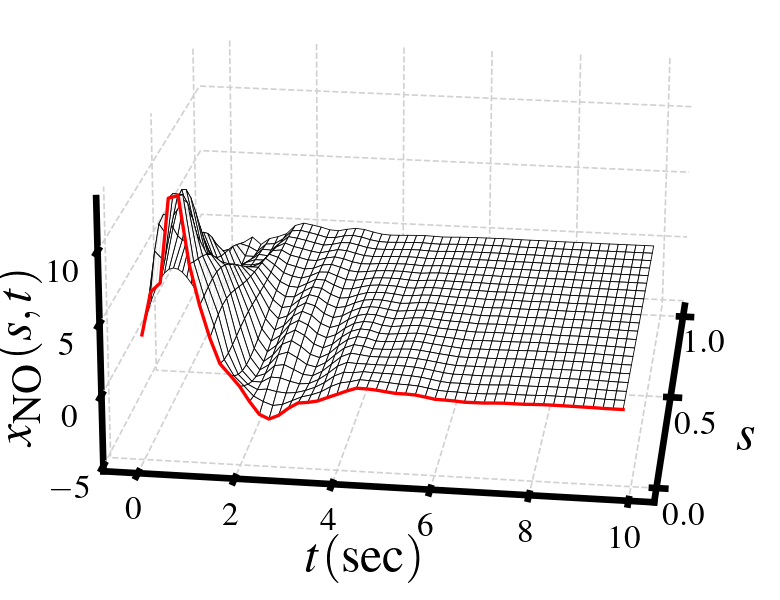

In [154]:
draw_rate = 40
nt_draw = (Maxstep + 1) // 2
temporal_draw = timeSequence[0:nt_draw:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw, indexing="ij")
test = np.zeros(len(temporal_draw))

%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

fig = plt.figure(figsize=(1.3, 1), dpi=my_dpi)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)

ax = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))

ax.plot_surface(meshx2, mesht2, X[0:nx, 0:nt_draw:draw_rate], edgecolor="black", lw=0.1, 
                color="white", shade=False, rasterized=True, alpha=0.9, antialiased=True, rstride=1, cstride=1, )
ax.plot(test, temporal_draw, X[0, 0:nt_draw:draw_rate], color="red", lw=0.4, antialiased=True)
ax.invert_xaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.7, 0.8]))  
ax.view_init(20, 8)
ax.set_xlabel(r"$s$", fontsize=6, labelpad=-15)
ax.set_ylabel(r"$t(\mathrm{sec})$", fontsize=6, labelpad=-15)
ax.yaxis.set_rotate_label(False)
ax.set_zlabel(r"$x_{\mathrm{NO}}(s,t)$", fontsize=6, rotation=90, labelpad=-16)
ax.set_xticks([0, 0.5, 1])
#ax.set_yticks(y_axis_ticks)
ax.set_zticks([-5, 0, 5, 10])

ax.zaxis.set_rotate_label(False)
ax.tick_params(axis='both', labelsize=4, pad=-6) 
plt.subplots_adjust(top=1.1, bottom=0, right=0.9, left=0, hspace=0, wspace=0)
plt.savefig('../picture2/1108/Little/x_little_1.png', dpi=my_dpi)

In [155]:
#numberical controller
x_u2 = np.zeros((N1 ** 2, Maxstep + 1))
xx2 = x_amp * np.cos(x_gamma * np.arccos(spatial - x_bias)) 
uu2 = np.zeros((N * N1, 1)).squeeze()
x_u2[:, 0] = np.hstack((xx2, uu2))
xx_uu2 = x_u2[:, 0]

start_time = time.time()

K, Kbud = iteration_k(4, g_bar, gammaTest, ampTest)
g_inverse_value = inverse_function(spatial, gammaTest, ampTest)
g_inverse_0 = g_inverse_value[0]

for tt in trange(Maxstep):
    uu_temps2 = np.around(xx_uu2[N1 : ].reshape((N, N1), order = "f"), 5).T
    uu_temps2 = np.hstack((uu_temps2, xx_uu2[N1 - 1] * np.ones((N+1,1))))   
    UCalc[tt] = solve_contrl_U(uu_temps2, K, Kbud, xx_uu2[:N1], gammaTest, ampTest, g_inverse_0)
    xx_uu2 = A @ x_u2[:, tt]
    xx_uu2[0] = UCalc[tt]
    x_u2[:, tt+1] = xx_uu2
end_time = time.time()
print("Analytical controller for large delay need", end_time - start_time)
X2 = x_u2[0 : N1, :]



100%|██████████| 4000/4000 [01:07<00:00, 59.68it/s]

Analytical controller for large delay need 72.01254081726074


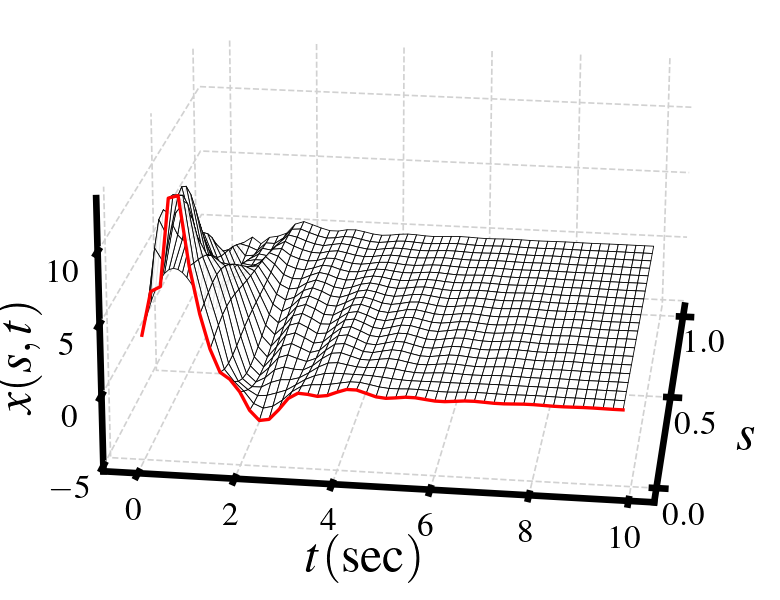

In [156]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
temporal_draw = timeSequence[0:nt_draw:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw, indexing="ij")
test = np.zeros(len(temporal_draw))

fig = plt.figure(figsize=(1.3, 1), dpi=my_dpi)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)

ax = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))

ax.plot_surface(meshx2, mesht2, X2[0:nx, 0:nt_draw:draw_rate], edgecolor="black", lw=0.1, 
                color="white", shade=False, rasterized=True, alpha=0.9, antialiased=True, rstride=1, cstride=1, )
ax.plot(test, temporal_draw, X2[0, 0:nt_draw:draw_rate], color="red", lw=0.4, antialiased=True)
ax.invert_xaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.7, 0.8])) 
ax.view_init(20, 8)
ax.set_xlabel(r"$s$", fontsize=6, labelpad=-15)
ax.set_ylabel(r"$t(\mathrm{sec})$", fontsize=6, labelpad=-15)
ax.yaxis.set_rotate_label(False)
ax.set_zlabel(r"$x(s,t)$", fontsize=6, rotation=90, labelpad=-16)
ax.set_xticks([0, 0.5, 1])
#ax.set_yticks(y_axis_ticks)
ax.set_zticks([-5, 0, 5, 10])

ax.zaxis.set_rotate_label(False)
ax.tick_params(axis='both', labelsize=4, pad=-6)  
plt.subplots_adjust(top=1.1, bottom=0, right=0.9, left=0, hspace=0, wspace=0)
plt.savefig('../picture2/1108/Little/x_little_2.png', dpi=my_dpi)



In [157]:
#NO under disturbance
UEstimate_NT = torch.zeros(Maxstep,  device=device, dtype=dtype)
tauTrue_N = tauTrue + add_gaussian_noise(tauTrue, noise_percentage)
tauTrueT = torch.from_numpy(tauTrue_N).to(device=device, dtype=dtype)
TauArray_N = tauTrueT.repeat((nx, 1))

x_u3 = torch.zeros((N1 ** 2, Maxstep + 1), device=device, dtype=dtype).squeeze()
xx3 = xx
uu3 = torch.zeros((N * N1, 1), device=device, dtype=dtype).squeeze()
x_u3[:, 0] = torch.cat((xx3, uu3))
xx_uu3 = x_u3[:, 0]

start_time = time.time()
with torch.no_grad():
    for tt in trange(Maxstep):
        uu_temps3 = xx_uu3[N1: ].reshape(N1, N)
        uu_temps3 = torch.cat((uu_temps3, xx_uu3[N1 - 1] * torch.ones((N+1,1), device=device, dtype=dtype)), dim = 1) 
        xArray3 = xx_uu3[:N1].repeat((nx, 1))
        Input3 = torch.stack([uu_temps3, TauArray_N, xArray3])
        Input3 = torch.unsqueeze(Input3, 0)
        UEstimate_NT[tt] = model2((Input3, girdEstimate))
        xx_uu3 = AT @ x_u3[:, tt] 
        xx_uu3[0] = UEstimate_NT[tt]
        x_u3[:, tt+1] = xx_uu3
X3 = x_u3[0 : N1, :].cpu().numpy()
end_time = time.time()
print("NO controller under noise needs:", end_time - start_time)


  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1229.91it/s]

NO controller under noise needs: 3.2540104389190674


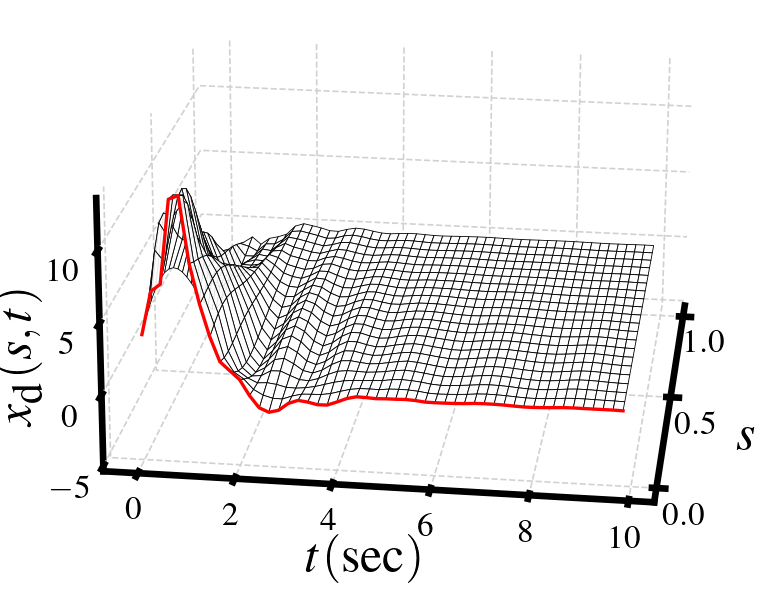

In [158]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
# nt_draw = Maxstep + 1
temporal_draw = timeSequence[0:nt_draw:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw, indexing="ij")
test = np.zeros(len(temporal_draw))

fig = plt.figure(figsize=(1.3, 1),dpi=my_dpi)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)

ax = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))

ax.plot_surface(meshx2, mesht2, X3[0:nx, 0:nt_draw:draw_rate], edgecolor="black", lw=0.1, 
                color="white", shade=False, rasterized=True, alpha=0.9, antialiased=True, rstride=1, cstride=1, )
ax.plot(test, temporal_draw, X3[0, 0:nt_draw:draw_rate], color="red", lw=0.4, antialiased=True)
ax.invert_xaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.7, 0.8])) 
ax.view_init(20, 8)
ax.set_xlabel(r"$s$", fontsize=6, labelpad=-15)
ax.set_ylabel(r"$t(\mathrm{sec})$", fontsize=6, labelpad=-15)
ax.yaxis.set_rotate_label(False)
ax.set_zlabel(r"$x_{\mathrm{d}}(s,t)$", fontsize=6, rotation=90, labelpad=-16)
ax.set_xticks([0, 0.5, 1])
ax.set_zticks([-5,0,5,10])
fig.tight_layout()
ax.zaxis.set_rotate_label(False)
ax.tick_params(axis='both', labelsize=4, pad=-6) 
plt.subplots_adjust(top=1.1, bottom=0, right=0.9, left=0, hspace=0, wspace=0)
plt.savefig('../picture2/1108/Little/x_little_3.png', dpi=my_dpi)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 3840x2880 with 0 Axes>

<Figure size 640x480 with 0 Axes>

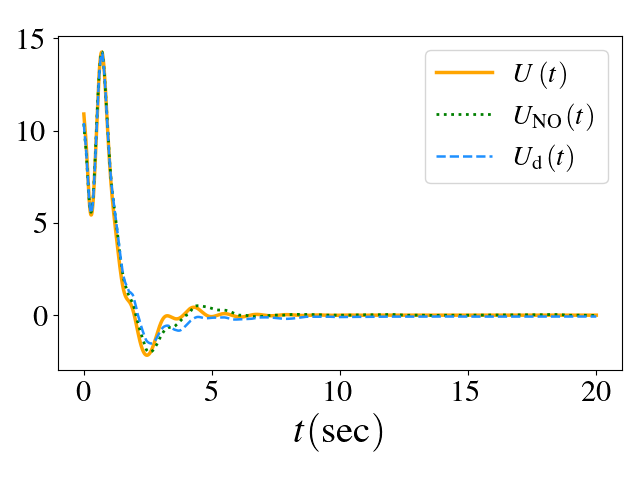

In [159]:

fig_intep=plt.figure( dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  

UEstimateTp = UEstimateT.cpu().numpy()
UEstimate_NTp = UEstimate_NT.cpu().numpy()
fig = plt.figure()
flg, ax = plt.subplots()
time2 = np.linspace(0, final_time, Maxstep)
ax.plot(time2, UCalc, label= r'$U\left(t\right)$', linewidth=2.5 ,color='orange', linestyle='solid')
ax.plot(time2, UEstimateTp, label=r'$U_{\mathrm{NO}}\left(t\right)$', linewidth=2,color='green', linestyle='dotted')
ax.plot(time2, UEstimate_NTp, label=r'$U_{\mathrm{d}}\left(t\right)$', linewidth=1.8,color='#1E90FF', linestyle='dashed')
plt.xlabel(r'$t(\mathrm{sec})$',fontsize="28")
plt.tick_params(labelsize=22)
fig = plt.gcf()
fig.tight_layout(pad=1.3)
ax.set_aspect(0.72)
plt.legend(loc="best",fontsize="20")


plt.savefig('../picture2/1108/Little/Compare.eps', dpi=my_dpi, format='eps',bbox_inches='tight', )



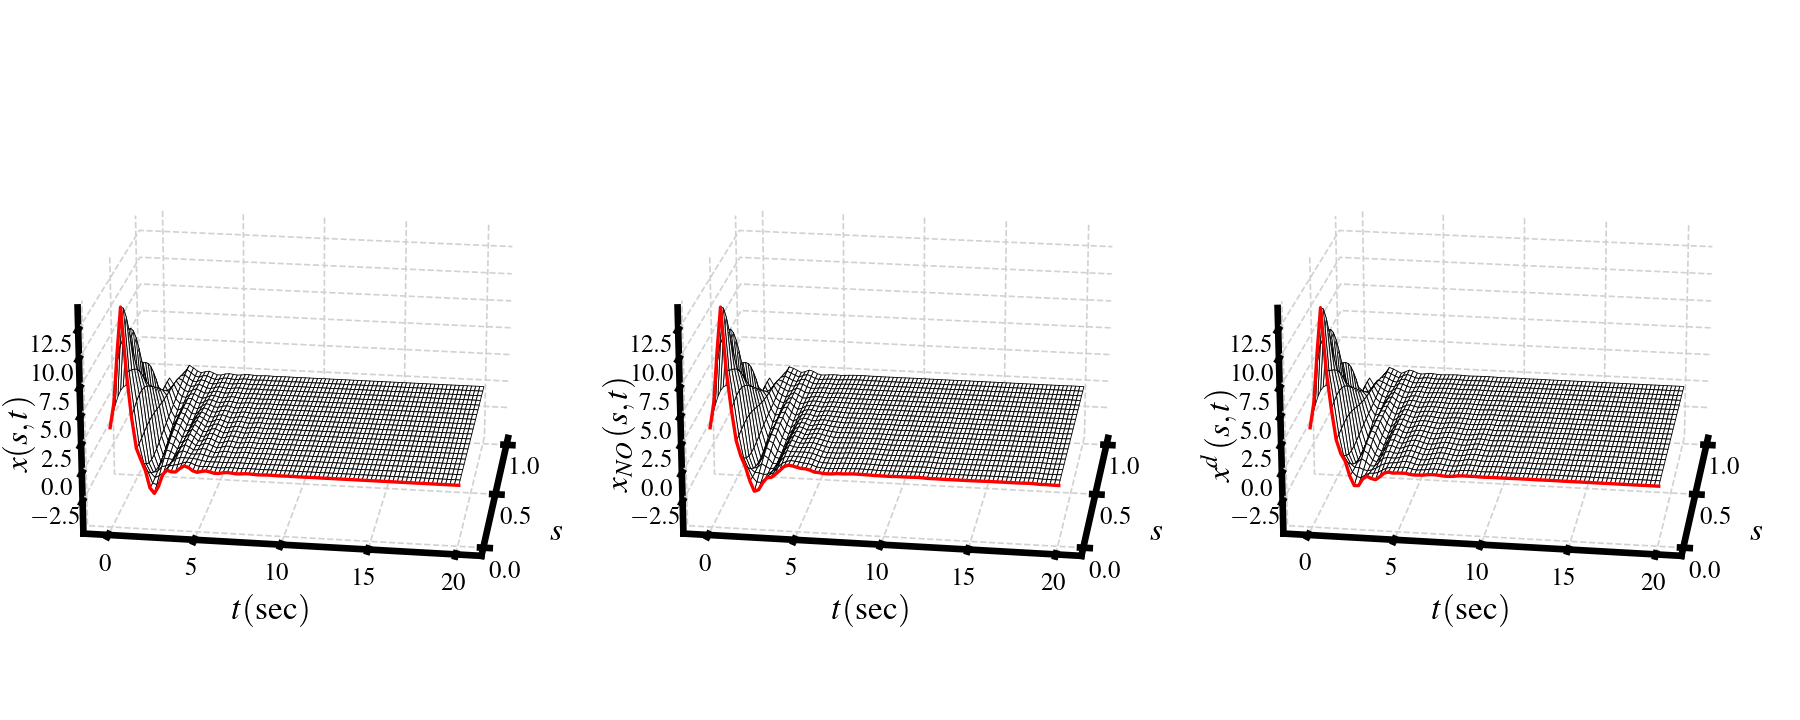

In [160]:
############### draw output
draw_rate = 50
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
nt_draw = Maxstep + 1
temporal_draw=timeSequence[0:nt_draw:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw, indexing="ij")
test=np.zeros(len(temporal_draw))
fig = plt.figure(figsize=(3, 1.2), dpi=my_dpi)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)
subfig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))

for axis in [ax[2].xaxis, ax[2].yaxis, ax[2].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    

ax[0].plot_surface(meshx2, mesht2, X2[0:nx, 0:nt_draw:draw_rate], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

ax[0].plot(test, temporal_draw, X2[0, 0:nt_draw:draw_rate], color="red", lw=0.4, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))

ax[0].view_init(20, 8)
ax[0].set_xlabel(r"$s$",fontsize = 4 , labelpad=-15)
ax[0].set_ylabel(r"$t(\mathrm{sec})$",fontsize = 4 , labelpad=-14)
ax[0].yaxis.set_rotate_label(False)
ax[0].set_zlabel(r"$x(s,t)$",fontsize = 4 , rotation = 90, labelpad=-16)
ax[0].set_xticks([0, 0.5, 1])


ax[0].zaxis.set_rotate_label(False)
ax[0].tick_params(axis='both', labelsize=3 , pad=-6)  


######################################################


ax[1].plot_surface(meshx2, mesht2, X[0:nx, 0:nt_draw:draw_rate], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

ax[1].plot(test, temporal_draw, X[0, 0:nt_draw:draw_rate], color="red", lw=0.4, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))

ax[1].view_init(20, 8)
ax[1].set_xlabel(r"$s$",fontsize = 4 , labelpad=-15)
ax[1].set_ylabel(r"$t(\mathrm{sec})$",fontsize = 4 , labelpad=-14)
ax[1].yaxis.set_rotate_label(False)
ax[1].set_zlabel(r"$x_{NO}(s,t)$", fontsize = 4 ,rotation = 90, labelpad=-16)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
#ax[1].set_yticks(y_axis_ticks)
#ax[1].set_zticks([-2, 0, 2, 4])

ax[1].tick_params(axis='both', labelsize=3, pad=-6 )  


ax[2].tick_params(axis='both', labelsize=3, pad=-6 )  

ax[2].plot_surface(meshx2, mesht2, X3[0:nx, 0:nt_draw:draw_rate], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

ax[2].plot(test, temporal_draw, X3[0, 0:nt_draw:draw_rate], color="red", lw=0.4, antialiased=True)
ax[2].invert_xaxis()
 
ax[2].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))

ax[2].view_init(20, 8)
ax[2].set_xlabel(r"$s$",fontsize = 4 , labelpad=-15)
ax[2].set_ylabel(r"$t(\mathrm{sec})$",fontsize = 4 , labelpad=-14)
ax[2].yaxis.set_rotate_label(False)
ax[2].set_zlabel(r"$x^d(s,t)$", fontsize = 4 ,rotation = 90, labelpad=-16)
ax[2].zaxis.set_rotate_label(False)
ax[2].set_xticks([0, 0.5, 1])
#ax[2].set_yticks(y_axis_ticks)
# ax[2].set_zticks([-2, 0, 2, 4])


ax[2].tick_params(axis='both', labelsize=3, pad=-6 ) 




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 600x600 with 0 Axes>

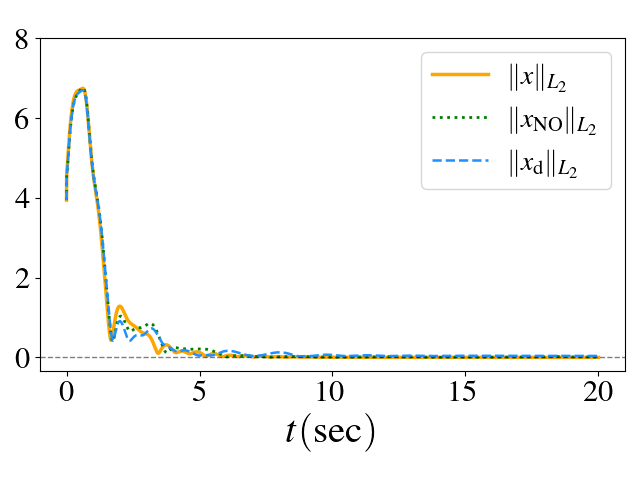

In [161]:
interL =  np.sqrt(np.sum(X**2, axis=0) * dx)
interL2 = np.sqrt(np.sum(X2**2, axis=0) * dx)
interL3 = np.sqrt(np.sum(X3**2, axis=0) * dx)
fig = plt.figure(figsize=(1,1), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False 
flg, ax = plt.subplots()
time2 = np.linspace(0, final_time, Maxstep+1)
ax.plot(time2, interL2, label=r"$\Vert x \Vert  _{L_2}$", linewidth=2.5 ,color='orange', linestyle='solid')
ax.plot(time2, interL, label=r"$\Vert x_{\mathrm{NO}} \Vert  _{L_2}$",linewidth=2,color='green', linestyle='dotted')
ax.plot(time2, interL3, label=r"$\Vert x_{\mathrm{d}}\Vert_{L_2}$", linewidth=1.8,color='#1E90FF', linestyle='dashed')
ax.set_yticks([0, 2, 4, 6, 8])

ax.axhline(y=0, color='black',alpha = 0.5 ,linestyle='--', linewidth=1)
plt.xlabel(r'$t(\mathrm{sec})$',fontsize="28")
plt.tick_params(labelsize=22)
fig = plt.gcf()
fig.tight_layout()
plt.legend(fontsize="20", loc="best")
ax.set_aspect(1.5)
plt.savefig('../picture2/1108/Little/L2.eps', dpi=my_dpi,bbox_inches='tight', format='eps')

plt.show()


<Figure size 3840x2880 with 0 Axes>

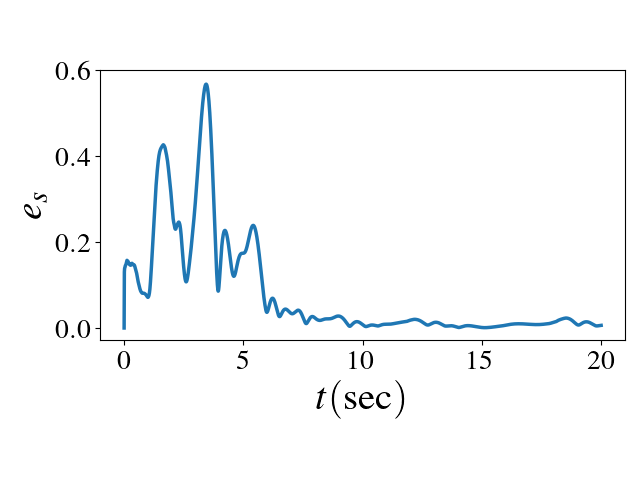

Mean value from last 30 point  0.007308438284336633


In [162]:
temp = np.sum((X - X2) * (X - X2) * dx, axis=0)
L2Norm = np.sqrt(temp)

fig = plt.figure(dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  
flg, ax = plt.subplots()
time2 = np.linspace(0, final_time, Maxstep+1)
ax.plot(time2, L2Norm, linewidth=2.5)
#ax.set_xticks(y_axis_ticks)
ax.set_yticks([0, 0.2, 0.4, 0.6])
#$'r'$\lVert x\left( \zeta ,t \right) \rVert _{L2}$'
plt.xlabel(r"$t(\mathrm{sec})$",fontsize="28")
plt.ylabel(r'$e_s$',fontsize="28")
plt.tick_params(labelsize=20)
fig = plt.gcf()
fig.tight_layout()
ax.set_aspect(18)
plt.savefig('../picture2/1108/Little/e_s_little.eps', dpi=my_dpi,bbox_inches='tight', format='eps')

plt.show()
print("Mean value from last 30 point ", np.mean(L2Norm[L2Norm.size - 100 : -1]))

100%|██████████| 800/800 [00:00<00:00, 1227.66it/s]


No controller for large delay needs: 0.6537618637084961


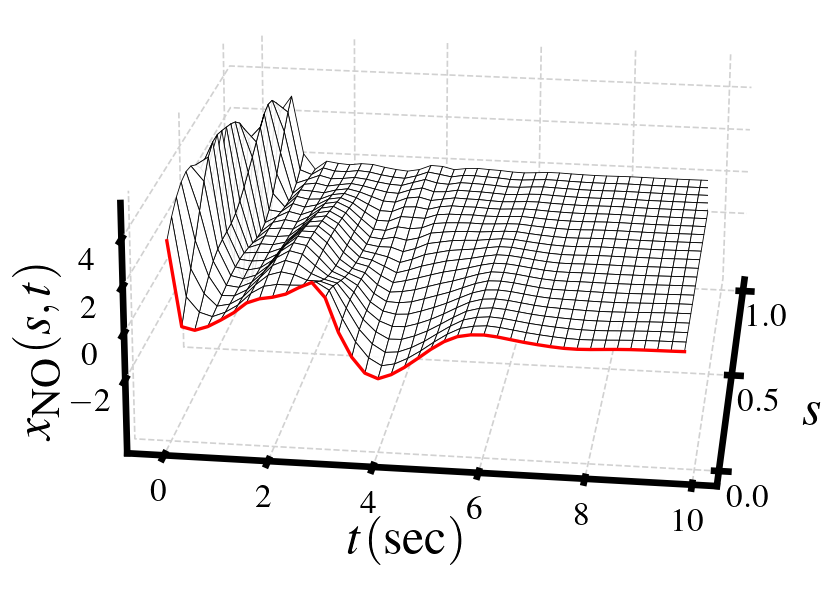

In [163]:
############Large case##############
ht = 0.025
gammaTau = 5.2
tauTrue = 3 + 0.5 * np.cos( gammaTau * np.arccos(spatial)) 
Maxstep_large = int(final_time / ht)
timeSequence_large = np.linspace(0, final_time, Maxstep_large + 1) 

UCalc_large = np.zeros(Maxstep_large)
lossU_large = np.zeros(Maxstep_large, dtype=np.float32)

coe_m = coefficient_matrix(nx)
A = get_cof_1(ht, dx, N, a, f1_m, cFunc(spatial), tauTrue)

#GPU参数部分
AT = torch.from_numpy(A.toarray()).to(device=device, dtype=dtype)
UEstimate_large = torch.zeros(Maxstep_large,  device=device, dtype=dtype)
tauTrueT = torch.from_numpy(tauTrue).to(device=device, dtype=dtype)
TauArray = tauTrueT.repeat((nx, 1))
#NO拟合的大时滞控制器
x_u_large = torch.zeros((N1 ** 2, Maxstep_large + 1), device=device, dtype=dtype).squeeze()
xx_large = xx
uu_large = torch.zeros((N * N1, 1), device=device, dtype=dtype).squeeze()
x_u_large[:, 0] = torch.cat((xx_large, uu_large))
xx_uu_large = x_u_large[:, 0]
start_time = time.time()

with torch.no_grad():
    for tt in trange(Maxstep_large):
        uu_temps1 = xx_uu_large[N1: ].reshape(N1, N)
        uu_temps1 = torch.cat((uu_temps1, xx_uu_large[N1 - 1] * torch.ones((N+1,1), device=device, dtype=dtype)), dim = 1) 
        xArray = xx_uu_large[:N1].repeat((nx, 1))
        Input = torch.stack([uu_temps1, TauArray, xArray])
        Input = torch.unsqueeze(Input, 0)
        UEstimate_large[tt] = model2((Input, girdEstimate))
        xx_uu_large = AT @ x_u_large[:, tt]#迭代   
        xx_uu_large[0] = UEstimate_large[tt]
        x_u_large[:, tt+1] = xx_uu_large
X_large = x_u_large[0 : N1, :].cpu().numpy()
end_time = time.time()
print("No controller for large delay needs:", end_time - start_time)
UEstimate_large = UEstimate_large.cpu().numpy()
[Time_large, Zeta_large] = np.meshgrid(timeSequence_large, spatial)

############### draw output
draw_rate_large = 10
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

nt_draw_large = (Maxstep_large + 1) // 2
temporal_draw_large=timeSequence_large[0:nt_draw_large:draw_rate_large]
meshx2_large, mesht2_large = np.meshgrid(spatial, temporal_draw_large, indexing="ij")
test_large=np.zeros(len(temporal_draw_large))

fig = plt.figure(figsize=(1.4, 1), dpi=my_dpi)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)

ax = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))

ax.plot_surface(meshx2_large, mesht2_large, X_large[0:nx, 0:nt_draw_large:draw_rate_large], edgecolor="black", lw=0.1, 
                color="white", shade=False, rasterized=True, alpha=0.9, antialiased=True, rstride=1, cstride=1, )
ax.plot(test_large, temporal_draw_large, X_large[0, 0:nt_draw_large:draw_rate_large], color="red", lw=0.4, antialiased=True)
ax.invert_xaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.6, 0.75]))  
ax.view_init(20, 8)
ax.set_xlabel(r"$s$", fontsize=6, labelpad=-15)
ax.set_ylabel(r"$t(\mathrm{sec})$", fontsize=6, labelpad=-15)
ax.yaxis.set_rotate_label(False)
ax.set_zlabel(r"$x_{\mathrm{NO}}(s,t)$", fontsize=6, rotation=90, labelpad=-16)
ax.set_xticks([0, 0.5, 1])

ax.set_zticks([-2, 0, 2, 4])

ax.zaxis.set_rotate_label(False)
ax.tick_params(axis='both', labelsize=4, pad=-6)  
plt.subplots_adjust(top=1.1, bottom=0, right=0.9, left=0, hspace=0, wspace=0)
plt.savefig('../picture2/1108/Great/x_great_1.png', dpi=my_dpi)



  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:05<00:00, 153.56it/s]


Analyzed controller large delay needs: 5.222475051879883


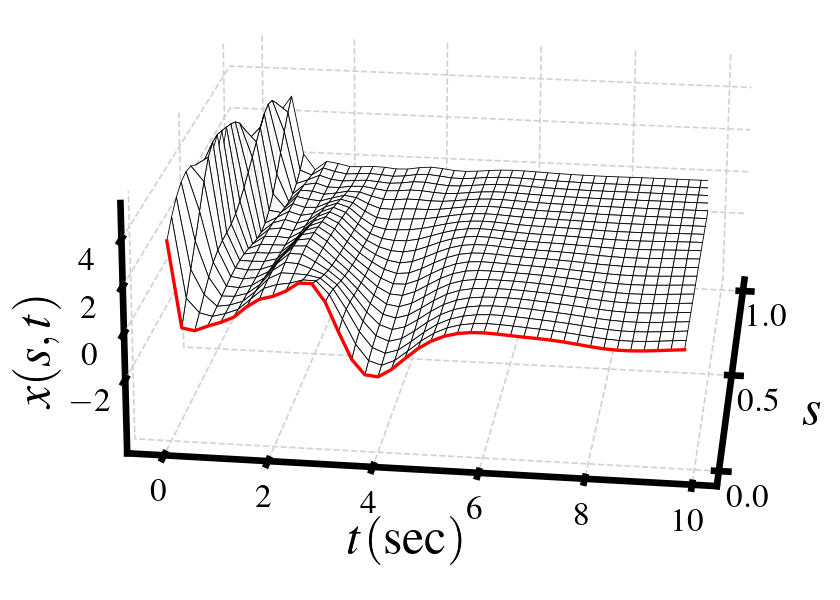

In [164]:
#numberical controller
x_u2_large = np.zeros((N1 ** 2, Maxstep_large + 1))
xx2_large = xx2 
uu2_large = np.zeros((N * N1, 1)).squeeze()
x_u2_large[:, 0] = np.hstack((xx2_large, uu2_large))
xx_uu2_large = x_u2_large[:, 0]

start_time = time.time()
K, Kbud =  KernelCalc2(1, dx, f1_m)

for tt in trange(Maxstep_large):
    uu_temps2 = np.around(xx_uu2_large[N1 : ].reshape((N, N1), order = "f"), 5).T
    uu_temps2 = np.hstack((uu_temps2, xx_uu2_large[N1 - 1] * np.ones((N+1,1))))   

    UCalc_large[tt] = solve_contrl_U2(uu_temps2, tauTrue, Kbud, xx_uu2_large[: N1], coe_m)
            
    xx_uu2_large = A @ x_u2_large[:, tt]#迭代   
    xx_uu2_large[0] = UCalc_large[tt]
    x_u2_large[:, tt+1] = xx_uu2_large
    
X2_large = x_u2_large[0 : N1, :]
end_time = time.time()
print("Analyzed controller large delay needs:", end_time - start_time)
############### draw output
fig = plt.figure(figsize=(1.4, 1), dpi=my_dpi)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)

ax = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))

ax.plot_surface(meshx2_large, mesht2_large, X2_large[0:nx, 0:nt_draw_large:draw_rate_large], edgecolor="black", lw=0.1, 
                color="white", shade=False, rasterized=True, alpha=0.9, antialiased=True, rstride=1, cstride=1, )
ax.plot(test_large, temporal_draw_large, X2_large[0, 0:nt_draw_large:draw_rate_large], color="red", lw=0.4, antialiased=True)
ax.invert_xaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.6, 0.75]))  
ax.view_init(20, 8)
ax.set_xlabel(r"$s$", fontsize=6, labelpad=-15)
ax.set_ylabel(r"$t(\mathrm{sec})$", fontsize=6, labelpad=-15)
ax.yaxis.set_rotate_label(False)
ax.set_zlabel(r"$x(s,t)$", fontsize=6, rotation=90, labelpad=-16)
ax.set_xticks([0, 0.5, 1])
#ax.set_yticks(y_axis_ticks)
ax.set_zticks([-2, 0, 2, 4])

ax.zaxis.set_rotate_label(False)
ax.tick_params(axis='both', labelsize=4, pad=-6)  
plt.subplots_adjust(top=1.1, bottom=0, right=0.9, left=0, hspace=0, wspace=0)
plt.savefig('../picture2/1108/Great/x_great_2.png', dpi=my_dpi)



100%|██████████| 800/800 [00:00<00:00, 1287.04it/s]


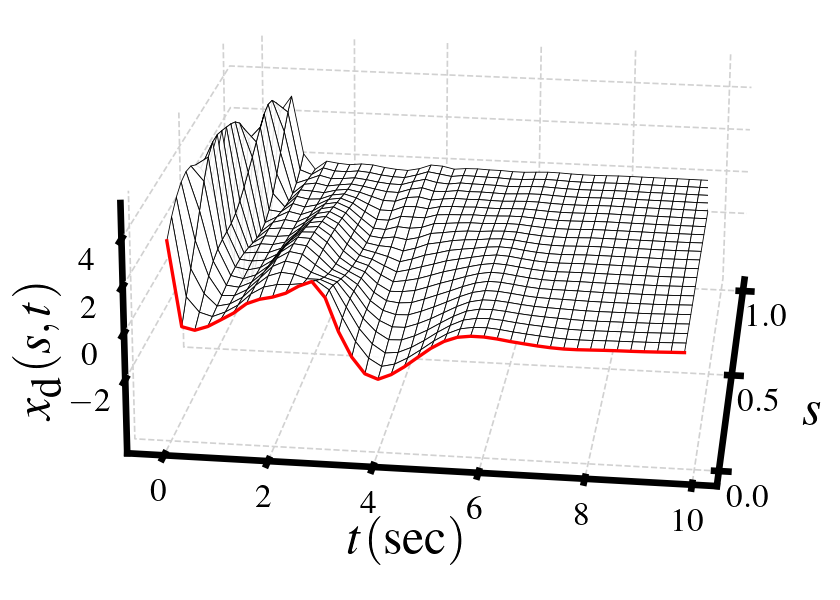

In [165]:
#NO under the disturbance
UEstimate_N_large = torch.zeros(Maxstep_large,  device=device, dtype=dtype)
tauTrue_N_G = tauTrue + add_gaussian_noise(tauTrue, noise_percentage)  #generateNoise(tauTrue, noise_percentage)#
tauTrueT_large = torch.from_numpy(tauTrue_N_G).to(device=device, dtype=dtype)
TauArray_N_large = tauTrueT_large.repeat((nx, 1))


x_u3_large = torch.zeros((N1 ** 2, Maxstep_large + 1), device=device, dtype=dtype).squeeze()
xx3_large = xx_large
#xx = 3* np.sin(3 * np.pi * spatial)
uu3_large = torch.zeros((N * N1, 1), device=device, dtype=dtype).squeeze()
x_u3_large[:, 0] = torch.cat((xx3_large, uu3_large))
xx_uu3_large = x_u3_large[:, 0]

start_time = time.time()
with torch.no_grad():
    for tt in trange(Maxstep_large):
        uu_temps3 = xx_uu3_large[N1: ].reshape(N1, N)
        uu_temps3 = torch.cat((uu_temps3, xx_uu3_large[N1 - 1] * torch.ones((N+1,1), device=device, dtype=dtype)), dim = 1) 
        xArray3 = xx_uu3_large[:N1].repeat((nx, 1))
        Input3 = torch.stack([uu_temps3, TauArray_N_large, xArray3])
        Input3 = torch.unsqueeze(Input3, 0)
        UEstimate_N_large[tt] = model2((Input3, girdEstimate))
        xx_uu3_large = AT @ x_u3_large[:, tt]#迭代   
        xx_uu3_large[0] = UEstimate_N_large[tt]
        x_u3_large[:, tt+1] = xx_uu3_large
    
X3_large = x_u3_large[0 : N1, :].cpu().numpy()
UEstimate_N_large = UEstimate_N_large.cpu().numpy()

############### draw output
fig = plt.figure(figsize=(1.4, 1), dpi=my_dpi)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)

ax = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))

ax.plot_surface(meshx2_large, mesht2_large, X3_large[0:nx, 0:nt_draw_large:draw_rate_large], edgecolor="black", lw=0.1, 
                color="white", shade=False, rasterized=True, alpha=0.9, antialiased=True, rstride=1, cstride=1, )
ax.plot(test_large, temporal_draw_large, X3_large[0, 0:nt_draw_large:draw_rate_large], color="red", lw=0.4, antialiased=True)
ax.invert_xaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.6, 0.75]))  # 前3个参数用来调整各坐标轴的缩放比例
ax.view_init(20, 8)
ax.set_xlabel(r"$s$", fontsize=6, labelpad=-15)
ax.set_ylabel(r"$t(\mathrm{sec})$", fontsize=6, labelpad=-15)
ax.yaxis.set_rotate_label(False)
ax.set_zlabel(r"$x_{\mathrm{d}}(s,t)$", fontsize=6, rotation=90, labelpad=-16)
ax.set_xticks([0, 0.5, 1])
#ax.set_yticks(y_axis_ticks)
ax.set_zticks([-2, 0, 2, 4])

ax.zaxis.set_rotate_label(False)
ax.tick_params(axis='both', labelsize=4, pad=-6)  # x轴标签旋转、字号等
plt.subplots_adjust(top=1.1, bottom=0, right=0.9, left=0, hspace=0, wspace=0)
plt.savefig('../picture2/1108/Great/x_great_3.png',  dpi=my_dpi)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.02969464


<Figure size 600x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

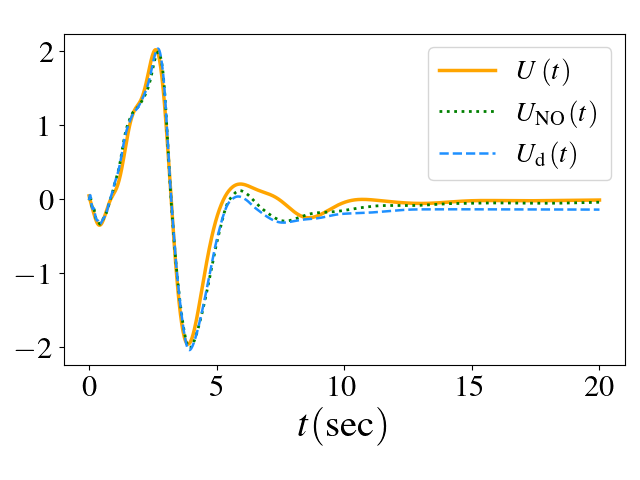

In [166]:

fig_intep=plt.figure(figsize=(1,1), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
lossU_large[:] = UCalc_large[:] - UEstimate_large[:] 
fig = plt.figure()
flg, ax = plt.subplots()
time2_large = np.linspace(0, final_time, Maxstep_large)
ax.plot(time2_large, UCalc_large, label= r'$U\left(t\right)$',linewidth=2.5 ,color='orange', linestyle='solid')
ax.plot(time2_large, UEstimate_large, label=r'$U_{\mathrm{NO}}\left(t\right)$' , linewidth=2,color='green', linestyle='dotted')
ax.plot(time2_large, UEstimate_N_large, label=r'$U_{\mathrm{d}}\left(t\right)$', linewidth=1.8,color='#1E90FF', linestyle='dashed')
plt.xlabel(r'$t(\mathrm{sec})$',fontsize="28")
plt.tick_params(labelsize=22)
#plt.ylim(-1, 1)
fig = plt.gcf()
fig.tight_layout()
plt.legend(loc="best",fontsize="20")
ax.set_aspect(2.9)
plt.savefig('../picture2/1108/Great/Compare.eps', dpi=my_dpi,bbox_inches='tight', format='eps')
print(np.abs(lossU_large[-1]))

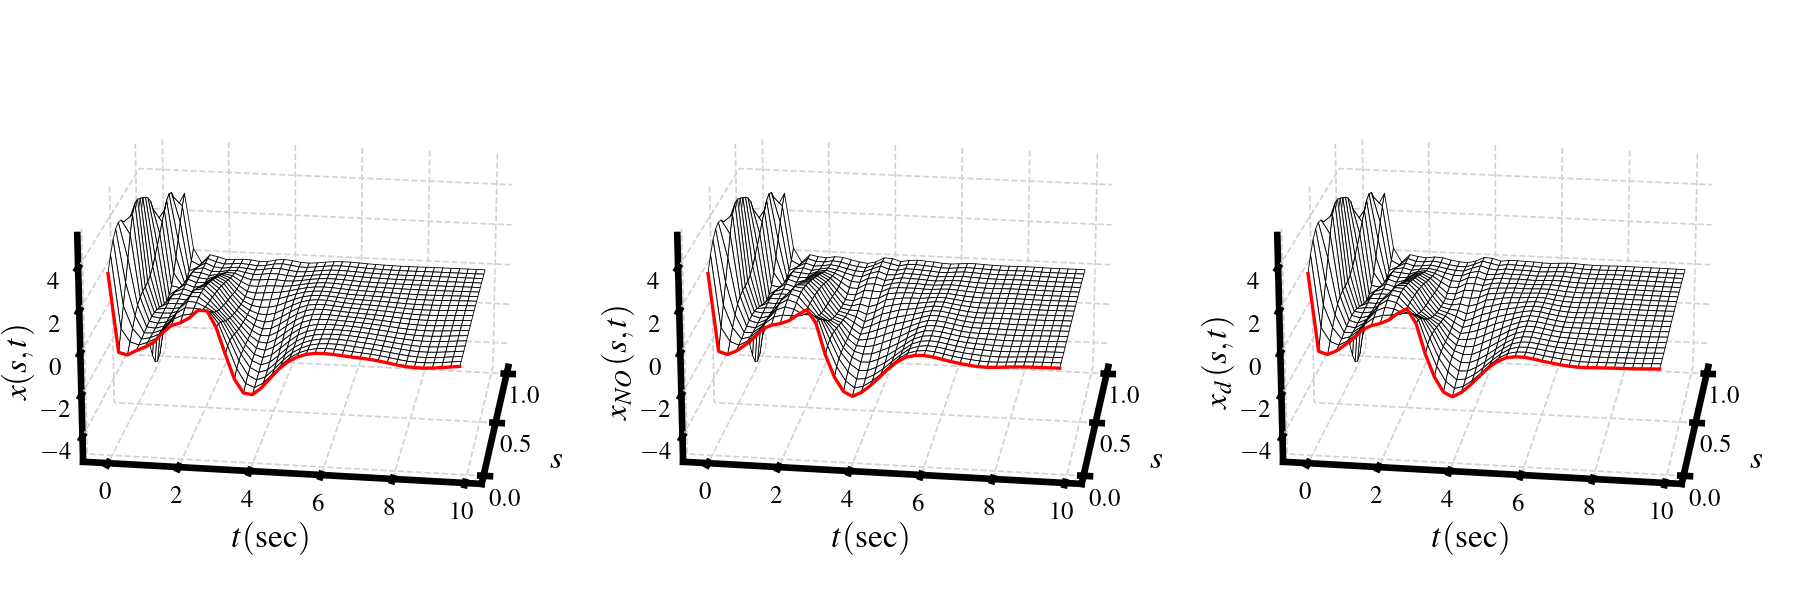

In [167]:
############### draw output
fig = plt.figure(figsize=(3, 1), dpi=my_dpi)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)
#subfig.suptitle("Dynamics of the close loop system for" + r" $\tau\in \mathcal{D}_1$" , fontsize=5, y=0.9)
subfig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[2].xaxis, ax[2].yaxis, ax[2].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.3
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    

ax[0].plot_surface(meshx2_large, mesht2_large, X2_large[0:nx, 0:nt_draw_large:draw_rate_large], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

ax[0].plot(test_large, temporal_draw_large, X2_large[0, 0:nt_draw_large:draw_rate_large], color="red", lw=0.4, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))

ax[0].view_init(20, 8)
ax[0].set_xlabel(r"$s$",fontsize = 4 , labelpad=-15)
ax[0].set_ylabel(r"$t(\mathrm{sec})$",fontsize = 4 , labelpad=-14)
ax[0].yaxis.set_rotate_label(False)
ax[0].set_zlabel(r"$x(s,t)$",fontsize = 4 , rotation = 90, labelpad=-16)
ax[0].set_xticks([0, 0.5, 1])
#ax[0].set_yticks(y_axis_ticks)
#ax[0].set_zticks([-2, 0, 2, 4])
ax[0].zaxis.set_rotate_label(False)
ax[0].tick_params(axis='both',  labelsize=3 , pad=-6)  
######################################################
ax[1].plot_surface(meshx2_large, mesht2_large, X_large[0:nx, 0:nt_draw_large:draw_rate_large], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

ax[1].plot(test_large, temporal_draw_large, X_large[0, 0:nt_draw_large:draw_rate_large], color="red", lw=0.4, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))

ax[1].view_init(20, 8)
ax[1].set_xlabel(r"$s$",fontsize = 4 , labelpad=-15)
ax[1].set_ylabel(r"$t(\mathrm{sec})$",fontsize = 4 , labelpad=-14)
ax[1].yaxis.set_rotate_label(False)
ax[1].set_zlabel(r"$x_{NO}(s,t)$", fontsize = 4 ,rotation = 90, labelpad=-16)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
#ax[1].set_yticks(y_axis_ticks)
#ax[1].set_zticks([-2, 0, 2, 4])
ax[1].tick_params(axis='both',  labelsize=3, pad=-6 ) 
ax[2].plot_surface(meshx2_large, mesht2_large, X3_large[0:nx, 0:nt_draw_large:draw_rate_large], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

ax[2].plot(test_large, temporal_draw_large, X3_large[0, 0:nt_draw_large:draw_rate_large], color="red", lw=0.4, antialiased=True)
ax[2].invert_xaxis()
ax[2].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))
ax[2].view_init(20, 8)
ax[2].set_xlabel(r"$s$",fontsize = 4 , labelpad=-15)
ax[2].set_ylabel(r"$t(\mathrm{sec})$",fontsize = 4 , labelpad=-14)
ax[2].yaxis.set_rotate_label(False)
ax[2].set_zlabel(r"$x_d(s,t)$", fontsize = 4 ,rotation = 90, labelpad=-16)
ax[2].zaxis.set_rotate_label(False)
ax[2].set_xticks([0, 0.5, 1])
ax[2].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=3, pad=-6 )  # x轴标签旋转、字号等


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 600x600 with 0 Axes>

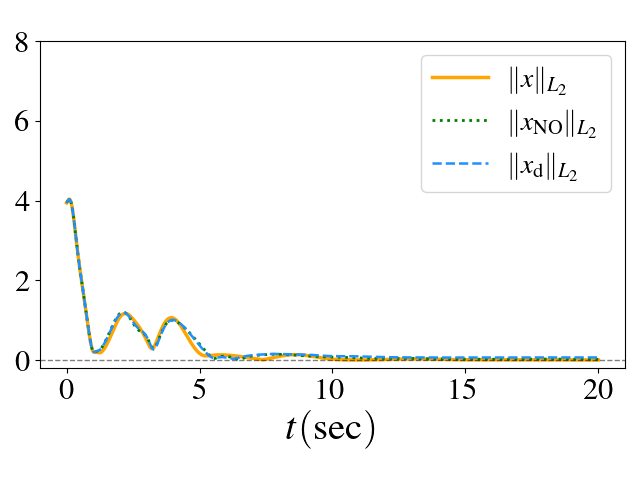

In [168]:
interL_large =  np.sqrt(np.sum(X_large**2, axis=0) * dx)
interL2_large = np.sqrt(np.sum(X2_large**2, axis=0) * dx)
interL3_large = np.sqrt(np.sum(X3_large**2, axis=0) * dx)
fig = plt.figure(figsize=(1,1), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  
flg, ax = plt.subplots()
time2_large = np.linspace(0, final_time, Maxstep_large+1)
ax.plot(time2_large, interL2_large, label=r"$\Vert x \Vert  _{L_2}$", linewidth=2.5 ,color='orange', linestyle='solid')
ax.plot(time2_large, interL_large, label=r"$\Vert x_{\mathrm{NO}} \Vert  _{L_2}$", linewidth=2,color='green', linestyle='dotted')
ax.plot(time2_large, interL3_large, label=r"$\Vert x_{\mathrm{d}} \Vert  _{L_2}$", linewidth=1.8,color='#1E90FF', linestyle='dashed')

ax.axhline(y=0, color='black',alpha = 0.5 ,linestyle='--', linewidth=1)

ax.set_yticks([0, 2, 4, 6, 8])
#ax.set_xticks(y_axis_ticks)
plt.xlabel(r'$t(\mathrm{sec})$',fontsize="28")
plt.tick_params(labelsize=22)
fig = plt.gcf()
fig.tight_layout()
plt.legend(fontsize="20", loc="best")
ax.set_aspect(1.5)
plt.savefig('../picture2/1108/Great/L2.eps', dpi=my_dpi,bbox_inches='tight', format='eps')
plt.show()


<Figure size 3840x2880 with 0 Axes>

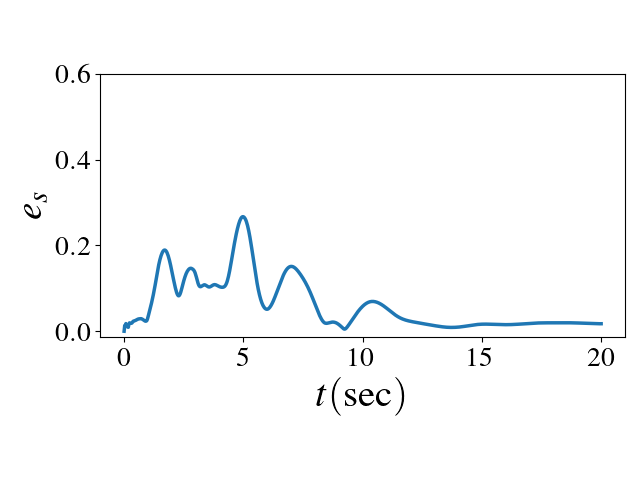

Mean value from last 30 point  0.019032853165813497


In [169]:
L2Norm_large = np.sqrt(np.sum((X_large - X2_large) * (X_large - X2_large) * dx, axis=0))

fig = plt.figure(dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  
flg, ax = plt.subplots()

ax.plot(time2_large, L2Norm_large, linewidth=2.5)
#ax.set_xticks(y_axis_ticks)
ax.set_yticks([0, 0.2, 0.4, 0.6])
#$'r'$\lVert x\left( \zeta ,t \right) \rVert _{L2}$'
plt.xlabel(r"$t(\mathrm{sec})$",fontsize="28")
plt.ylabel(r'$e_s$',fontsize="28")
plt.tick_params(labelsize=20)
fig = plt.gcf()
fig.tight_layout()
ax.set_aspect(18)
plt.savefig('../picture2/1108/Great/e_s_great.eps', dpi=my_dpi,bbox_inches='tight', format='eps')

plt.show()
print("Mean value from last 30 point ", np.mean(L2Norm_large[L2Norm_large.size - 100 : -1]))